In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import igraph as ig
from networkx.algorithms import community
from time import time

ModuleNotFoundError: No module named 'igraph'

In this notebook, we use the Louvain and Leiden algorithms to detect communities in the co-authorship graph and build features from these partitions.

# Community detection with Louvain and Leiden

Here we use the Louvain and Leiden algorithms to detect the communities in the co-authorship graph.

In [76]:
# Load the graph
G = nx.read_edgelist('../Data/coauthorship.edgelist', delimiter=' ', nodetype=int)

# Load the graph in igraph
g = ig.Graph.from_networkx(G)

In [77]:
louvain_partition = g.community_multilevel()
leiden_partition = g.community_leiden(objective_function='modularity')

print("Louvain partition modularity: {:.4}".format(g.modularity(louvain_partition)))
print("Leiden partition modularity:  {:.4}".format(g.modularity(leiden_partition)))

Louvain partition modularity: 0.8641
Leiden partition modularity:  0.8673


In [78]:
print("Louvain: " + louvain_partition.summary())
print("Leiden: " + leiden_partition.summary())

Louvain: Clustering with 217801 elements and 186 clusters
Leiden: Clustering with 217801 elements and 247 clusters


We work the Leiden partition for the rest of the notebook.

##### Partition graph

IGRAPH U--- 247 1415 -- 


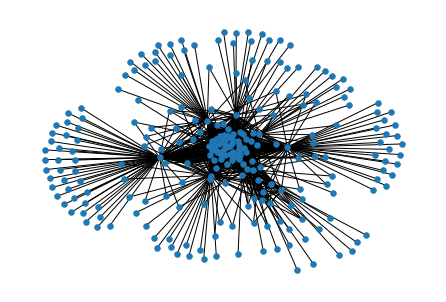

In [79]:
pg = leiden_partition.cluster_graph()
ig.summary(pg)

# Transferring the partition graph over to networkx
pg.write_edgelist(f = '../Graphs/partition1.edgelist')
pG = nx.read_edgelist('../Graphs/partition1.edgelist', delimiter=' ', nodetype=int)

nx.draw(pG, node_size = 30)

##### Looking at the clusters

In [80]:
lei_mem = leiden_partition.membership

In [82]:
cluster_size = []
for k in range(max(lei_mem) + 1):
    cluster_size.append(lei_mem.count(k))

print("Number of clusters: " + str(max(lei_mem) + 1))
print("Size of the largest cluster: {}".format(max(cluster_size)))
print("Size of the smallest cluster: {}".format(min(cluster_size)))
print("Average size of clusters: {}".format(int(np.mean(cluster_size))))

Number of clusters: 247
Size of the largest cluster: 15795
Size of the smallest cluster: 6
Average size of clusters: 881


We can take a node to check that its neighbors are in the same community.

In [97]:
idx = list(G.nodes())

# Input any node here
node = 671527850
print("Cluster of the node: " + str(lei_mem[rev_idx[node]]))

rev_idx = {}
for i,ii in enumerate(idx):
    rev_idx[ii] = i

neigh_cluster = []
for neigh in G[node]:
    neigh_cluster.append(lei_mem[rev_idx[neigh]])

print("\nCluster of the neighbors:")
print(neigh_cluster)

Cluster of the node: 10

Cluster of the neighbors:
[10, 1, 10, 5, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8, 10, 10, 10, 10]


##### Checking that the indexing is consistent with the networkx graph

In [87]:
communities = [set() for k in range(max(lei_mem) + 1)]
for i, node in enumerate(idx):
    communities[lei_mem[i]].add(node)

community.modularity(G, communities)

0.867278236338548

##### Writing the partition to file

In [88]:
# Write
with open('../Data/partition.txt', 'w') as filehandle:
    for listitem in lei_mem:
        filehandle.write('%s\n' % listitem)

In [67]:
# Read
lei_mem = []

with open('../Data/partition.txt', 'r') as filehandle:
    for line in filehandle:
        lei_mem.append(line[:-1])

# Community-based features

Here we try to build features that crucially exploit the community partitionning. The first idea of such a feature is the number and ratio of edges outside of its community that a node has.

In [91]:
idx = list(G.nodes())
rev_idx = {}
for i,ii in enumerate(idx):
    rev_idx[ii] = i

ex_num = {}
ex_ratio = {}

for i, node in enumerate(idx):
    s = 0
    node_cluster = lei_mem[i]
    for neigh in G[node]:
        s += (node_cluster != lei_mem[rev_idx[neigh]])
    ex_num[node] = s
    ex_ratio[node] = s / G.degree(node)

In [99]:
with open('../Data/ex_num.csv', 'w', encoding='utf-8') as f:
    for key in ex_num.keys():
        f.write('%s,"%s"\n'%(key,ex_num[key]))

with open('../Data/ex_ratio.csv', 'w', encoding='utf-8') as f:
    for key in ex_ratio.keys():
        f.write('%s,"%s"\n'%(key,ex_ratio[key]))

# Community-specific features

Here we compute node features that can only be computed on small graphs by only taking into account the community subgraph.

In [110]:
# Cluster -> nodes dictionnary
cluster_nodes = {}
for i,ii in enumerate(idx):
    if not lei_mem[i] in cluster_nodes.keys():
        cluster_nodes[lei_mem[i]] = [ii]
    else:
        cluster_nodes[lei_mem[i]].append(ii)

# First we obtain the subgraphs for each community
cluster_subgraph = {}
for c in cluster_nodes:
    cluster_subgraph[c] = G.subgraph(cluster_nodes[c])

Graph with 66 nodes and 120 edges


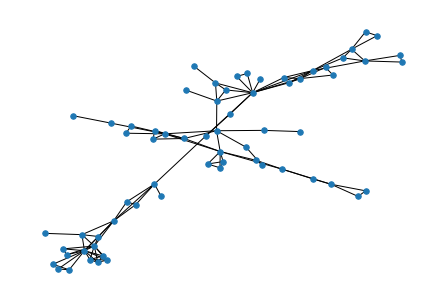

In [131]:
# Taking a look at a small subgraph
print(cluster_subgraph[20])
nx.draw(cluster_subgraph[20], node_size = 30)

In [149]:
# Computing the centrality for each community
cluster_info_cen = {}
for c in cluster_subgraph:
    print(c)
    cluster_info_cen[c] = nx.information_centrality(cluster_subgraph[c])

0
10
1
5
44
76
14
59
17
2
4
21
7
29
19
13
8
34
43
35
25
22
27
51
30
12
39
61
106
28
108
69
31
16
9
15
58
38
107
83
37
77
46
78
81
36
151
200
53
70
152
166
178
64
24
40
201
62
120
52
68
63
202
18
11
188
187
90
170
156
60
104
203
204
205
175
206
207
208
209
210
128
211
212
213
214
189
126
26
103
67
215
41
79
216
132
71
133
197
167
168
217
169
218
219
220
127
134
135
80
160
84
136
121
221
82
105
23
95
96
222
54
223
224
225
91
20
122
92
45
137
226
180
181
153
93
6
94
227
228
109
196
229
230
191
231
177
110
55
111
129
232
154
112
192
233
138
198
33
190
182
234
65
235
139
113
123
161
171
42
85
193
86
140
87
194
176
165
141
183
142
56
114
72
32
172
195
236
100
184
237
47
157
115
88
89
162
48
155
116
179
163
238
73
199
97
124
239
57
240
241
117
3
130
143
101
158
242
243
66
144
145
74
164
146
244
245
118
98
99
185
186
147
119
148
125
246
149
131
159
102
150
173
174
75
49
50
